# Model architecture

The model is built in the function `NN` below. The model can be customized with various arguments, but the general structure is as follows:

* **Text Vectorizer**: this encodes the input string to a sequence of integers. The layer will produce sequences of length up to 100, and each *word* is encoded as an integer. Hence input strings should ideally have length at most 100 to avoid lost information. The size of the vocabulary can be customized.
* **Embedding layer**: the input sequences are embedded into $n$-dimensional space. You may choose $n$, and you may also try using embeddings pretrained using GloVe (for `embed_layer` enter either "glove 50" or "glove 50 trainable" for the 50 dimensional embeddings, making this layer either trainable or not. GloVe embeddings may be 50, 100, 200 or 300 dimensional.)
* **Dropout layer**: the dropout rate can be set with by `Dropout_rate`. The same rate is used for all dropout layers.
* **Convolutional layers**: by default none are used. The number of filters and filter size can be customized. If used, the `Conv1D` layer is followed by a **max pooling** layer (the pooling size can be customized) and a **dropout layer**.
* **LSTM layers**: you may choose how many layers, how many unites and whether to use kernel regularization. You may also choose whether you want the layers to be bidirectional or not (with the `BRNN` argument).
* **Dropout layer**
* **Dense layers**: you may choose how many layers to use, and how many neurons in each layer. You may also set the regularization and whether to use batch normalization.
* **Dropout layer**
* **Output layer**: one neuron with sigmoid activation to output classification probabilities.

The `TextVectorizer` layer needs to be initialized first, and is done so with the `vect_layer_maker` function. It is here where you can choose the vocabulary size.

If using the GloVe embeddings, then these need to be initialized too. Use the `get_glove_embedding_layer` to do this, which returns a pretrained embedding layer.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Activation, BatchNormalization, TextVectorization, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from time import time
from functools import partial
from zipfile import ZipFile
from helper_functions import * # functions defined in helper_functions.py

In [2]:
def vect_layer_maker(X_train, vocab_size=10000, sequence_length=100):
    vectorize_layer = TextVectorization(max_tokens = vocab_size,
                                        output_mode='int',
                                        output_sequence_length=100,
                                        name='vectorizer'
                                       )
    vectorize_layer.adapt(X_train)
    return vectorize_layer

In [3]:
def get_glove_embedding_layer(vectorizer_layer, embed_dim=300, trainable=False):
    # First get the vectors            
    glove_dict = {}
    if embed_dim not in [50,100,200,300]:
        raise ValueError('Glove embedding dimensions are 50, 100, 200 or 300 only.')
    filename = f'../input/glove6b/glove.6B.{embed_dim}d.txt'
    with open(filename) as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = values[1:]
            glove_dict[word] = np.asarray(vector, dtype='float32')
    # Create vocab dictionary from the vectorizer layer
    vocab_list = vectorizer_layer.get_vocabulary()
    vocab_dict = {word : index for index, word in enumerate(vocab_list)}
    # Next create the matrix
    embedding_matrix = np.zeros((len(vocab_dict)+1, embed_dim))
    for word, index in vocab_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    # Now create and return the layer
    return Embedding(input_dim = len(vocab_dict)+1,
                     output_dim = embed_dim,
                     trainable = trainable,
                     weights = [embedding_matrix]
                    )

In [4]:
def NN(embed_layer = 32,
       Conv_filters=None,
       Conv_filter_size=3,
       Conv_pool_size=2,
       LSTM_layers=2, 
       LSTM_units=64, 
       LSTM_kernel_reg=None,
       BRNN=False,
       Dense_layers=1, 
       Dense_units=128, 
       Dense_reg=None,
       Batch_norm=False,
       Dropout_rate=0,
       learning_rate=0.001
      ):
    '''
    Builds and compiles RNN.
    
    Args:
        embed_layer: int (dimension of embedding) or pre-built keras layer
        LSTM_layers: int  -- number of LSTM layers, come after the embedding layer
        LSTM_units: int
        LSTM_kernel_reg:  tf.keras.regularizers object for regularization of input weights
        Dense_layers: int  -- number of Dense layers afer LSTM
        Dense_units: int
        Dense_reg: tf.keras.regularizers object for regularization of weights
        Dropout_rate: float (default 0 = no dropout)  -- dropout rate for dropout layers
        
    Returns:
        compiled model
    '''
    model = Sequential()
    # vectorization layer
    model.add(vectorize_layer)
    # Embedding layer
    if isinstance(embed_layer, int):
        embed_layer = Embedding(vocab_size+1, embed_layer)
    else:
        model.add(tf.keras.layers.Input(shape=[100], dtype=tf.string))
        if embed_layer in [f'glove {x}' for x in [50,100,200,300]]:
            embed_dim = int(re.findall(r'\d+', embed_layer)[0])
            embed_layer = get_glove_embedding_layer(vectorize_layer, embed_dim=embed_dim, trainable=False)
        elif embed_layer in [f'glove {x} trainable' for x in [50,100,200,300]]:
            embed_dim = int(re.findall(r'\d+', embed_layer)[0])
            embed_layer = get_glove_embedding_layer(vectorize_layer, embed_dim=embed_dim, trainable=True)
        else:
            raise ValueError('Embedding layer format not recognized. Should be either integer for trainable embedding of that dimension, or either "glove x" or "glove x trainable", for x = 50, 100, 200, 300')
    model.add(embed_layer)
    # Dropout layer
    model.add(Dropout(Dropout_rate))
    # Add Conv layer (optional)
    if Conv_filters != None:
        model.add(Conv1D(filters=Conv_filters, kernel_size=Conv_filter_size, padding = 'same', activation='relu', name='Conv1D'))
        model.add(MaxPooling1D(pool_size=Conv_pool_size, name='MaxPool'))
        model.add(Dropout(Dropout_rate))
    # add LSTM layers
    if BRNN:
        if LSTM_layers>1:
            for i in range(LSTM_layers-1):
                model.add(Bidirectional(LSTM(LSTM_units, return_sequences = True, kernel_regularizer = LSTM_kernel_reg, name = f'LSTM_{i}')))
        else:
            i=0
        model.add(Bidirectional(LSTM(LSTM_units, name = f'LSTM_{i+1}')))
        
    else:
        if LSTM_layers>1:
            for i in range(LSTM_layers-1):
                model.add(LSTM(LSTM_units, return_sequences = True, kernel_regularizer = LSTM_kernel_reg, name = f'LSTM_{i}'))
        else:
            i=0
        model.add(LSTM(LSTM_units, name = f'LSTM_{i+1}'))
    # Another dropout layer
    model.add(Dropout(Dropout_rate))
    # add fully connected layers
    for i in range(Dense_layers):
        model.add(Dense(Dense_units, kernel_initializer = 'he_uniform', activation=None, kernel_regularizer=Dense_reg, name = f'Dense_{i}'))
        if Batch_norm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
    # Another dropout layer
    model.add(Dropout(Dropout_rate))
    # add final layer, outputting proability speech is Tory
    model.add(Dense(1, activation='sigmoid', name = 'output_layer'))
    # compile
    Adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
    
    return model

# The grid search begins...

In [5]:
train_ds, val_ds, test_ds = load_data(batch_size=512) # load the data

vocab_size=30000
vectorize_layer = vect_layer_maker(train_ds.map(lambda x,y:x), vocab_size=vocab_size, sequence_length=100)

In [7]:
reg = l2(0.01)
reg2 = l2(0.1)
n_repeats = 1
history_log = grid_search(NN, train_ds, val_ds, n_repeats = n_repeats, n_epochs=10, early_stopping_patience=6,verbose=1,
                                   embed_layer = [16],
                                   Conv_filters=[16],
                                   Conv_filter_size=[5],
                                   Conv_pool_size=[2],
                                   LSTM_layers=[2], 
                                   LSTM_units=[32], 
                                   LSTM_kernel_reg=[reg2],
                                   BRNN=[True],
                                   Dense_layers=[2], 
                                   Dense_units=[64], 
                                   Dense_reg=[reg2],
                                   Batch_norm=[True],
                                   Dropout_rate=[0.3],
                                   learning_rate=[0.0001]
                                  )

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 32.2115 - accuracy: 0.4949

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 963s 4s/step - loss: 32.2115 - accuracy: 0.4949 - val_loss: 28.0134 - val_accuracy: 0.5627
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 24.7097 - accuracy: 0.5084

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1401s 6s/step - loss: 24.7097 - accuracy: 0.5084 - val_loss: 21.5015 - val_accuracy: 0.5627
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 18.9154 - accuracy: 0.5525

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1227s 5s/step - loss: 18.9154 - accuracy: 0.5525 - val_loss: 16.4165 - val_accuracy: 0.6239
Epoch 4/10
235/235 [==============================] - ETA: 0s - loss: 14.3765 - accuracy: 0.6487

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1352s 6s/step - loss: 14.3765 - accuracy: 0.6487 - val_loss: 12.4465 - val_accuracy: 0.6795
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 10.8586 - accuracy: 0.7174

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1554s 7s/step - loss: 10.8586 - accuracy: 0.7174 - val_loss: 9.4593 - val_accuracy: 0.6785
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 8.1576 - accuracy: 0.7533

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1887s 8s/step - loss: 8.1576 - accuracy: 0.7533 - val_loss: 7.0748 - val_accuracy: 0.7283
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 6.0891 - accuracy: 0.7820

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 2070s 9s/step - loss: 6.0891 - accuracy: 0.7820 - val_loss: 5.3580 - val_accuracy: 0.7171
Epoch 8/10
235/235 [==============================] - ETA: 0s - loss: 4.5140 - accuracy: 0.8037

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1486s 6s/step - loss: 4.5140 - accuracy: 0.8037 - val_loss: 3.9443 - val_accuracy: 0.7548
Epoch 9/10
235/235 [==============================] - ETA: 0s - loss: 3.3302 - accuracy: 0.8195

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1510s 6s/step - loss: 3.3302 - accuracy: 0.8195 - val_loss: 2.9449 - val_accuracy: 0.7613
Epoch 10/10
235/235 [==============================] - ETA: 0s - loss: 2.4431 - accuracy: 0.8345

INFO:tensorflow:Assets written to: model_params_0_run_0\assets


INFO:tensorflow:Assets written to: model_params_0_run_0\assets


235/235 [==============================] - 1497s 6s/step - loss: 2.4431 - accuracy: 0.8345 - val_loss: 2.2269 - val_accuracy: 0.7453


ValueError: No such layer: Vectorizer. Existing layers are: ['vectorizer', 'embedding_1', 'dropout_4', 'Conv1D', 'MaxPool', 'dropout_5', 'bidirectional_2', 'bidirectional_3', 'dropout_6', 'Dense_0', 'batch_normalization_2', 'activation_2', 'Dense_1', 'batch_normalization_3', 'activation_3', 'dropout_7', 'output_layer'].

-----------------------
Parameter lookup table:
-----------------------


,Dropout_rate,LSTM_kernel_reg,Conv_pool_size,embed_layer,Conv_filters,LSTM_layers,Batch_norm,BRNN,learning_rate,LSTM_units,...,mean_val_accuracy,best_anytime_val_accuracy,Mean run time (mins),best_anytime_full_val_loss,best_anytime_full_val_accuracy,mean_full_val_loss,mean_full_val_accuracy,Val_loss mean trend at end,Number of runs,Number of epochs
Parameter Index,,,,,,,,,,,,,,,,,,,,,
0,0.3,<keras.regularizers.L2 object at 0x7f7900a46410>,2,16,None,2,True,True,0.0001,32,...,0.763644,0.793067,48.804776,0.467998,0.859464,0.520067,0.842134,0.00106,3,25


-----------------------
Training set, run 0:
-----------------------
              precision    recall  f1-score   support

           0       0.47      0.47      0.47     56376
           1       0.53      0.52      0.53     63624

    accuracy                           0.50    120000
   macro avg       0.50      0.50      0.50    120000
weighted avg       0.50      0.50      0.50    120000

-----------------------
Training set, run 1:
-----------------------
              precision    recall  f1-score   support

           0       0.47      0.48      0.47     56376
           1       0.53      0.52      0.52     63624

    accuracy                           0.50    120000
   macro avg       0.50      0.50      0.50    120000
weighted avg       0.50      0.50      0.50    120000

-----------------------
Training set, run 2:
-----------------------
              precision    recall  f1-score   support

           0       0.47      0.52      0.49     56376
           1       0.53      0

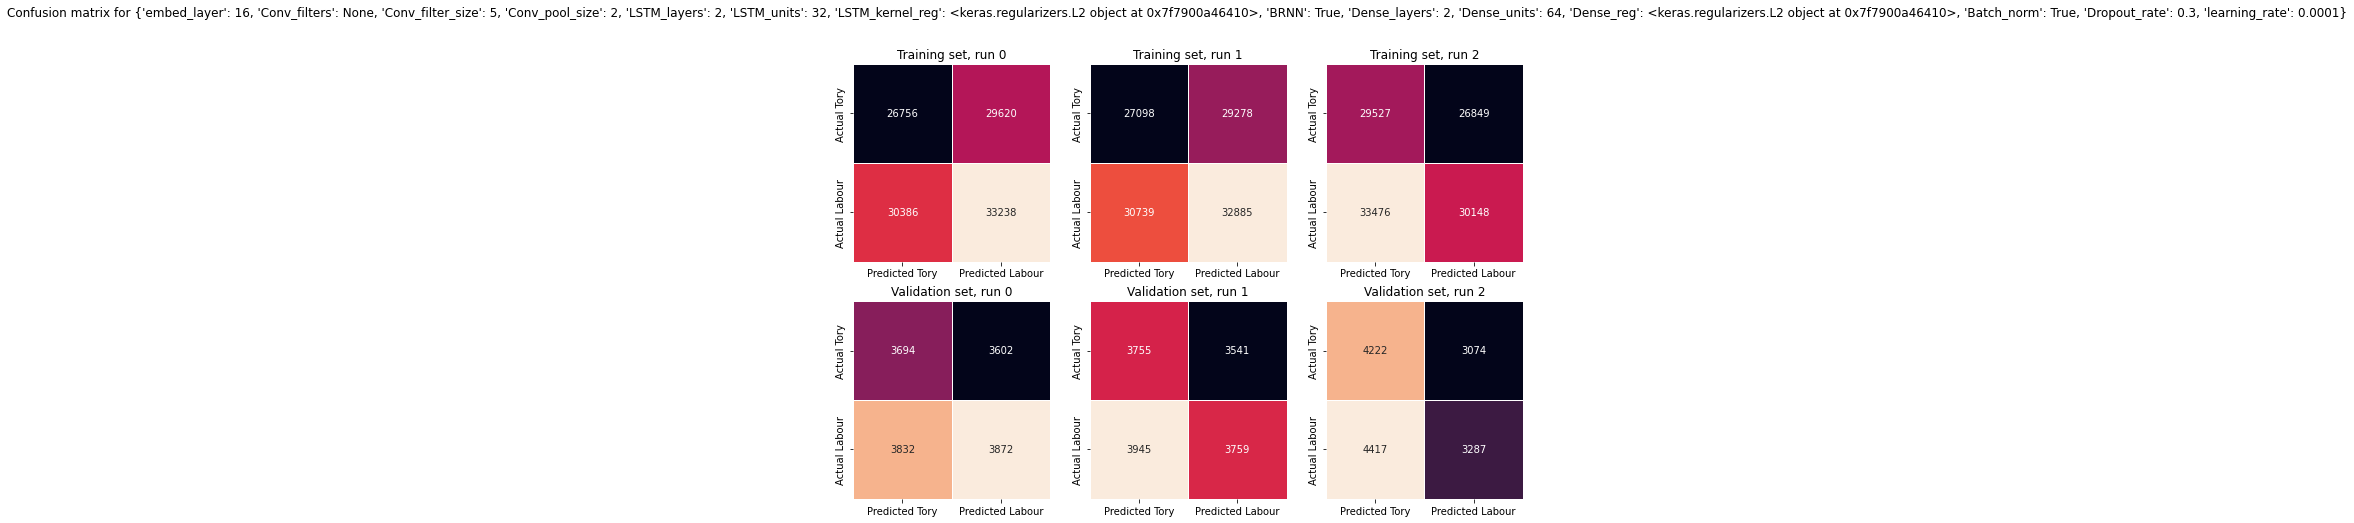

In [ ]:
visualize_log(history_log)